### Importando Libs do Spark

In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import split
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler, VectorIndexer
from pyspark.ml.classification import MultilayerPerceptronClassifier, NaiveBayes, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

### Importando dados e analisando os dados

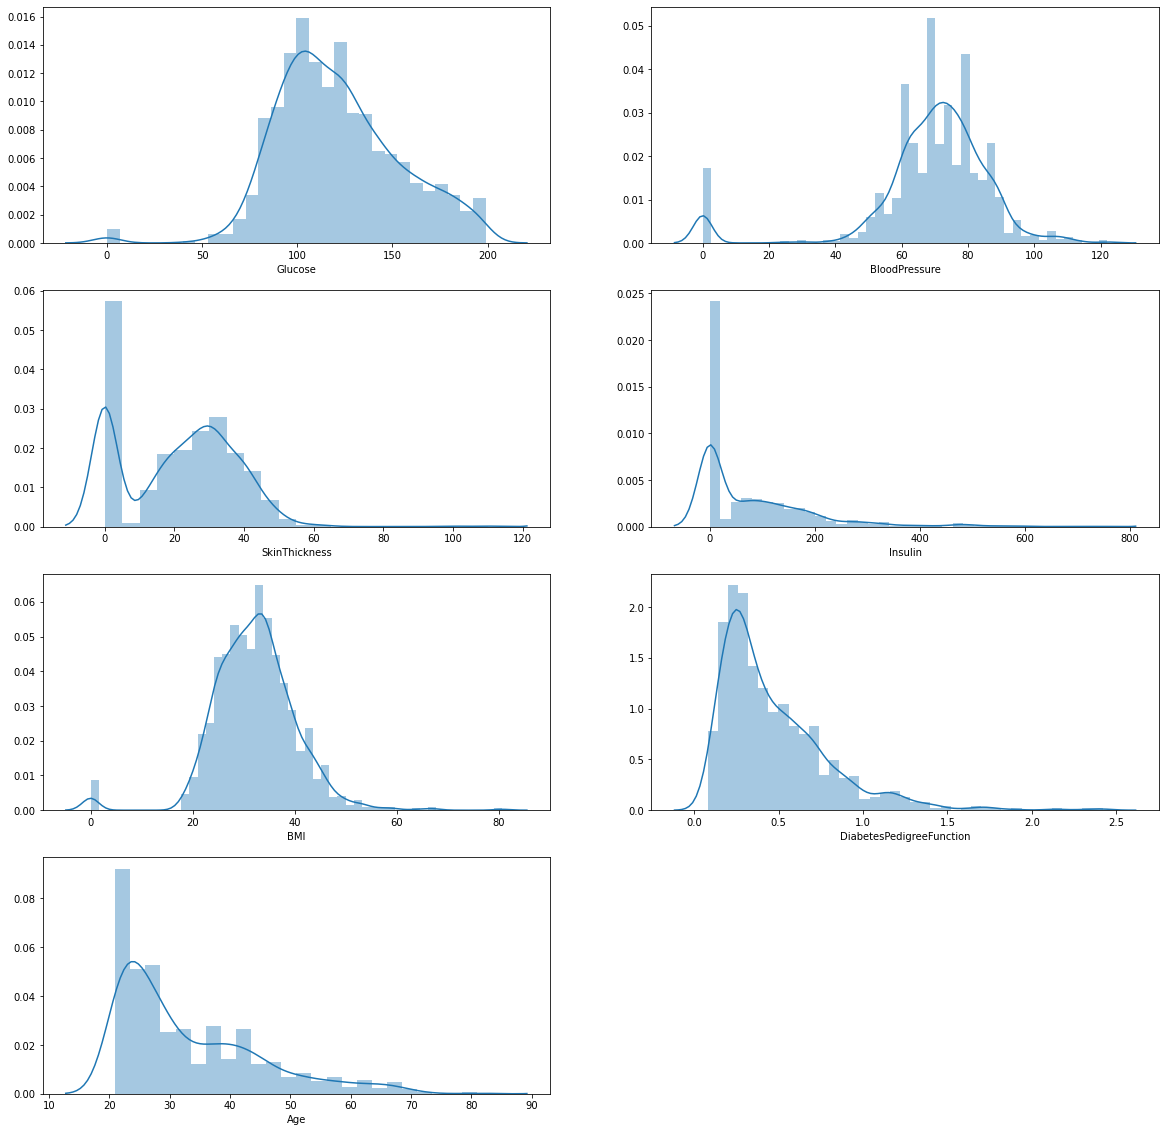

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_path = "./diabetes-dataset.csv"
df = pd.read_csv(data_path)

fig=plt.figure(figsize=(20,20))
for i,col in enumerate(df.drop(['Pregnancies','Outcome'],axis=1)):
    ax=fig.add_subplot(4,2,i+1)
    sns.distplot(df[col])

In [4]:
df.groupby('Outcome').count()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,1316,1316,1316,1316,1316,1316,1316,1316
1,684,684,684,684,684,684,684,684


### Balaceando dados

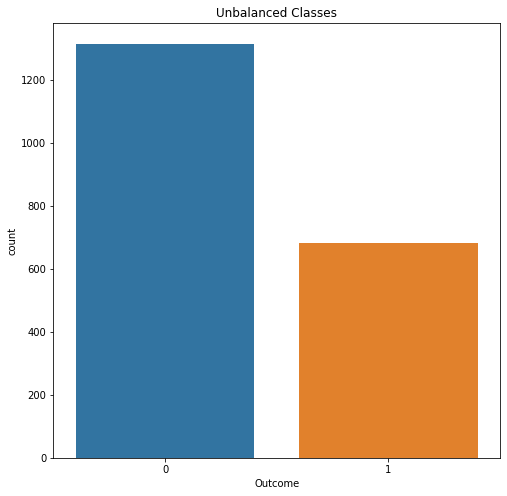

In [5]:
plt.figure(figsize=(8, 8))
sns.countplot('Outcome', data=df)
plt.title('Unbalanced Classes')
plt.show()

### Criando sessão do Spark

In [6]:
spark = SparkSession.builder.master("local[*]").appName("Assignment").getOrCreate()

In [7]:
orig_data = spark.read.format("csv").options(sep=',',header='true',inferschema='true').load(data_path)

### Ajustando dados para treinar os modelos

In [8]:
indexer = StringIndexer(inputCol="Outcome", outputCol="label").fit(orig_data)
label_data = indexer.transform(orig_data)

# Save the inverse map from numeric "label" to string "class" to be used further in response
labelReverse = IndexToString().setInputCol("label")

# Show labeled dataframe with numeric lable
print("Dataframe with numeric lable")
label_data.show(5)

Dataframe with numeric lable
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+-----+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|label|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+-----+
|          2|    138|           62|           35|      0|33.6|                   0.127| 47|      1|  1.0|
|          0|     84|           82|           31|    125|38.2|                   0.233| 23|      0|  0.0|
|          0|    145|            0|            0|      0|44.2|                    0.63| 31|      1|  1.0|
|          0|    135|           68|           42|    250|42.3|                   0.365| 24|      1|  1.0|
|          1|    139|           62|           41|    480|40.7|                   0.536| 21|      0|  0.0|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+-----+
only showing top 

In [9]:
# Drop string column "class", no string column
label_data = label_data.drop("Outcome")

# Most Machine Learning Lib inpute 2 columns: label (output) and feature (input)
# The label column is the result to train ML algorithm 
# The feature column should join all parameters as a Vector

# Set the column names that is not part of features list
ignore = ['label']
# list will be all columns parts of features
list = [x for x in label_data.columns if x not in ignore]

# VectorAssembler mount the vector of features
assembler = VectorAssembler(
            inputCols=list,
            outputCol='features')

# Create final dataframe composed by label and a column of features vector
data = (assembler.transform(label_data).select("label","features"))

print("Final Dataframe suitable to classifier input format")
data.show(5)

Final Dataframe suitable to classifier input format
+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|[2.0,138.0,62.0,3...|
|  0.0|[0.0,84.0,82.0,31...|
|  1.0|(8,[1,5,6,7],[145...|
|  1.0|[0.0,135.0,68.0,4...|
|  0.0|[1.0,139.0,62.0,4...|
+-----+--------------------+
only showing top 5 rows



### Spliting dados e treinando os modelos

In [10]:
train_sample = 0.7
test_sample = 0.3

#### Decision Tree

In [11]:
from pyspark.sql.functions import col, explode, array, lit

major_df = data.filter(col("label") == 1.0)
minor_df = data.filter(col("label") == 0.0)
ratio = int(minor_df.count()/major_df.count())

##### Oversampling

In [12]:
a = range(ratio)
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
combined_df = major_df.unionAll(oversampled_df)

In [13]:
(train, test) = combined_df.randomSplit([train_sample, test_sample], 1234)

In [14]:
trainer = DecisionTreeClassifier(featuresCol='features', labelCol='label', predictionCol='prediction', probabilityCol='probability',\
                                 rawPredictionCol='rawPrediction', maxDepth=10, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0,\
                                 maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, impurity='gini', seed=None)

# train the model and get the result
model = trainer.fit(train)
result_dt = model.transform(test)

In [15]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",\
            metricName="accuracy")

accuracy_dt = evaluator.evaluate(result_dt) * 100
print("Decision Tree: accuracy = %3.1f %%" % accuracy_dt)

Decision Tree: accuracy = 83.0 %


In [16]:
print("Decision Tree Final Result")
result_dt.show(5)

Decision Tree Final Result
+-----+--------------------+-------------+--------------------+----------+
|label|            features|rawPrediction|         probability|prediction|
+-----+--------------------+-------------+--------------------+----------+
|  1.0|(8,[0,1,6,7],[10....|    [0.0,1.0]|           [0.0,1.0]|       1.0|
|  1.0|(8,[0,1,6,7],[10....|    [0.0,1.0]|           [0.0,1.0]|       1.0|
|  1.0|(8,[1,5,6,7],[119...| [494.0,41.0]|[0.92336448598130...|       0.0|
|  1.0|[0.0,95.0,85.0,25...| [494.0,41.0]|[0.92336448598130...|       0.0|
|  1.0|[0.0,104.0,64.0,3...| [494.0,41.0]|[0.92336448598130...|       0.0|
+-----+--------------------+-------------+--------------------+----------+
only showing top 5 rows



In [17]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = result_dt.select(['label']).collect()
y_pred = result_dt.select(['prediction']).collect()

In [18]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87       371
         1.0       0.80      0.69      0.74       201

    accuracy                           0.83       572
   macro avg       0.82      0.80      0.81       572
weighted avg       0.83      0.83      0.83       572



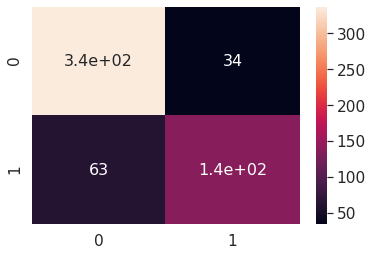

In [19]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

df_cm = confusion_matrix(y_true,y_pred)
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})

plt.show()

##### Undersampling

In [20]:
sampled_majority_df = major_df.sample(False, 1/ratio)
combined_df_2 = sampled_majority_df.unionAll(minor_df)
combined_df_2.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|[2.0,138.0,62.0,3...|
|  1.0|(8,[1,5,6,7],[145...|
|  1.0|[0.0,135.0,68.0,4...|
|  1.0|[4.0,125.0,70.0,1...|
|  1.0|[7.0,195.0,70.0,3...|
+-----+--------------------+
only showing top 5 rows



In [21]:
(train_2, test_2) = combined_df_2.randomSplit([train_sample, test_sample], 1234)

In [22]:
trainer_2 = DecisionTreeClassifier(featuresCol='features', labelCol='label', predictionCol='prediction', probabilityCol='probability',\
                                 rawPredictionCol='rawPrediction', maxDepth=10, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0,\
                                 maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, impurity='gini', seed=None)

# train the model and get the result
model_2 = trainer_2.fit(train_2)
result_dt_2 = model_2.transform(test_2)

In [23]:
evaluator_2 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",\
            metricName="accuracy")

accuracy_dt_2 = evaluator_2.evaluate(result_dt_2) * 100
print("Decision Tree: accuracy = %3.1f %%" % accuracy_dt_2)

Decision Tree: accuracy = 92.3 %


#### Naive Bayes

In [24]:
# create the trainer and set its parameters
trainer = NaiveBayes(smoothing=1.0, modelType="multinomial")

# train the model and get the result
model = trainer.fit(train)
result_nb = model.transform(test)

In [25]:
# compute accuracy on the test set against model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",\
            metricName="accuracy")

accuracy_nb = evaluator.evaluate(result_nb) * 100
print("Naive Bayes: accuracy = %3.1f %%" % accuracy_nb)

Naive Bayes: accuracy = 62.8 %


In [26]:
print("Naive Bayes Final Result")
result_nb.show(5)

Naive Bayes Final Result
+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  1.0|(8,[0,1,6,7],[10....|[-249.16076274539...|[4.48019661956082...|       1.0|
|  1.0|(8,[0,1,6,7],[10....|[-249.16076274539...|[4.48019661956082...|       1.0|
|  1.0|(8,[1,5,6,7],[119...|[-269.42461457532...|[0.00136375916766...|       1.0|
|  1.0|[0.0,95.0,85.0,25...|[-516.53348350970...|[0.99981703024682...|       0.0|
|  1.0|[0.0,104.0,64.0,3...|[-557.54892560806...|[0.99306753219492...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [27]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = result_nb.select(['label']).collect()
y_pred = result_nb.select(['prediction']).collect()

In [28]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.72      0.70      0.71       371
         1.0       0.47      0.50      0.49       201

    accuracy                           0.63       572
   macro avg       0.60      0.60      0.60       572
weighted avg       0.63      0.63      0.63       572



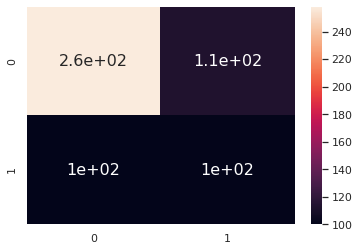

In [29]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

df_cm = confusion_matrix(y_true,y_pred)
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})

plt.show()